In [161]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import BasePromptTemplate
from langchain_core.output_parsers import JsonOutputParser

from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, List, Optional, Union

import json

In [162]:
load_dotenv()

model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [163]:
class Comment(TypedDict, total=False):
    user: Optional[str]
    comment: str
    text: Optional[str]
    sentiment: Optional[str]


class PostState(TypedDict, total=False):
    
    post_id: int
    post_description: str
    username: str
    
    comments: List[Union[Optional[Comment], str]]
    
    summary: str
    positive_sentiment: int
    negative_sentiment: int
    score: int
    overall_sentiment: str
    
    comments_detailed: List[Union[Optional[Comment], str]]
    
    error: str

In [164]:
graph = StateGraph(PostState)

In [165]:

def check_comment_exist(state: PostState) -> PostState:
    print("Check Comment Exist")
    return state

def generate_summary(state: PostState):
    
    post = state['post_description']
    comments = state['comments']
    
    print("Generate Summary")
    
    prompt = f"""You are a Professional People's comments content analyzer, Generate a short descriptive summary about what peoples say about the posts.
    
    Original Post is: ${post}
    Comments are : ${comments}
    
    """
    
    result = model.invoke(prompt).content
    
    # print(result)
    
    return {'summary': result}

def check_sentiment(state: PostState):
    
    print("Check Sentiment")
    
    
    post = state['post_description']
    comments = state['comments']
    
    json_schema = {
            
    "positive_sentiment": 0,
    "negative_sentiment": 0,
    "score": 0,
    "overall_sentiment":["positive", "negative", "neutral"],
    "comments":[
        {
            "comment": "",
            "sentiment":["positive", "negative", "neutral"]
        }
    ]
    }
    
    prompt = f"""You are a Professional People's comments content analyzer, Analyze the following comment and return its sentiment (positive, negative, or neutral) and count of positive comments and negative comments
    and a score between 0 and 5
    
    Original Post is: ${post}
    Comments are : ${comments}
    
    Return a JSON object.
    
    ${json_schema}

    
    """
    
    
    result = model.invoke(prompt)    
    content = result.content.strip("```json\n").strip("```")

    # Parse the JSON string into a Python dictionary
    data = json.loads(content)
      
    # print(result)  
    # Extracting the overall sentiment counts and score
    positive_sentiment = data['positive_sentiment']
    negative_sentiment = data['negative_sentiment']
    overall_sentiment = data['overall_sentiment']
    score = data['score']

    # Extracting comments and their sentiment
    comments_detailed = data['comments']
    
    
    
    
    
    return { 'positive_sentiment': positive_sentiment, 'negative_sentiment': negative_sentiment, 'score': score, 'comments_detailed':comments_detailed, 'overall_sentiment':overall_sentiment}
    # return { 'positive_sentiment': 0, 'negative_sentiment': 0, 'score': 0, 'comments_detailed':""}

def store_db(state: PostState):
    return state

def show_errors_post(state: PostState):
    print(f'Post not found')
    return {'error': f'Post not found'}

def show_error_comments(state: PostState):
    comments = state['comments']
    print(f'Total Comment(s) Found: ${len(comments)}')
    return {'error': f'Total Comment(s) Found: ${len(comments)}'}

def data_formatting(state: PostState):
    print("Data Formatting Node")
    lists = state['comments']
    finalList = [data['comment'] for data in lists]
        
    
    return {'comments': finalList}


def post_conditional(state: PostState) -> Literal["check_comment_exist", "show_errors_post"]:
    post = state['post_description']
    
    if len(post) > 0:
        return "check_comment_exist"
    else:
        return "show_errors_post"
        
        
def comment_conditional(state: PostState) -> Literal["data_formatting", "show_error_comments"]:
        
    lists = state['comments']
    
    if len(lists) > 5:
        return "data_formatting"
    else:
        return "show_error_comments"

In [166]:
graph.add_node("show_errors_post", show_errors_post)

graph.add_node("check_comment_exist", check_comment_exist)
graph.add_node("show_error_comments", show_error_comments)

graph.add_node("data_formatting", data_formatting )

graph.add_node("generate_summary", generate_summary)
graph.add_node("check_sentiment", check_sentiment)
graph.add_node("store_db", store_db)

In [ ]:
graph.add_conditional_edges(START, post_conditional)
graph.add_edge("show_errors_post", END)
graph.add_conditional_edges("check_comment_exist", comment_conditional)
graph.add_edge("show_error_comments", END)

graph.add_edge("data_formatting", "generate_summary")
graph.add_edge("data_formatting", "check_sentiment")
graph.add_edge("generate_summary", "store_db")
graph.add_edge("check_sentiment", "store_db")

graph.add_edge("store_db", END)

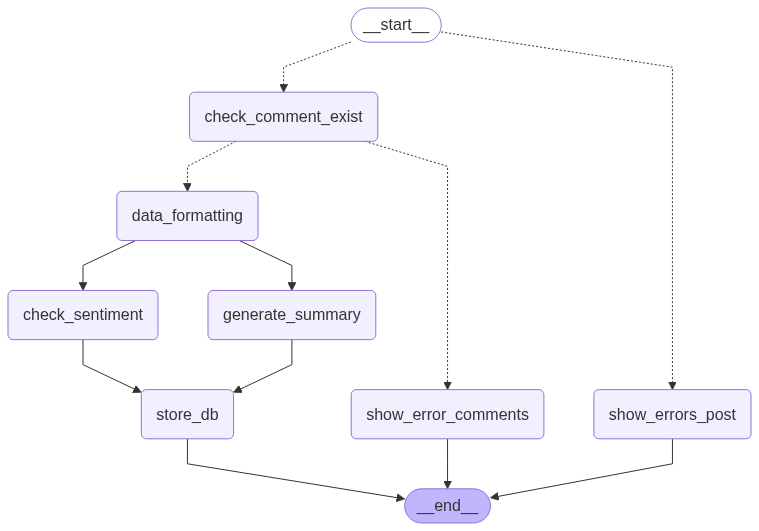

In [168]:
workflow = graph.compile()
workflow

In [169]:
# Load the corrected JSON data from the file
try:
    with open('fakeData.json', 'r', encoding='utf-8') as file:
        data = json.load(file)
except FileNotFoundError:
    print("File not found. Please check the file path.")
except json.JSONDecodeError:
    print("Error decoding JSON. Please check the file format.")
except Exception as e:
    print(f"An error occurred: {e}")

In [170]:

post_id = int(input("Enter Post Id"))
# post_id = 3
post = data['posts'][post_id-1]
comments = post['comments']

initial_state = {
    'post_id': post_id,
    'post_description': post['content'],
    'username': post['user'],
    
    'comments': comments
}

# type(post['content'])

# print({'post_description': post['content']})


final_state = workflow.invoke(initial_state)

print("Summary:\t", final_state['summary'])
print("Overall Sentiment:\t", final_state['overall_sentiment'])
print("Positive Comments:\t", final_state['positive_sentiment'])
print("Negative Comments:\t", final_state['negative_sentiment'])
print("Overall Score:\t", final_state['score'])
print("Comments:\t", final_state['comments_detailed'])



Check Comment Exist
Data Formatting Node
Check Sentiment
Generate Summary
Summary:	 Commenters overwhelmingly gush over Luna's adorableness and congratulate the poster on adopting her.  Many offer helpful advice for new pet parents, focusing on providing chew toys, crate training, puppy classes for socialization, and the importance of patience during training.  There's also a strong expression of excitement to see more pictures of Luna in the future.
Overall Sentiment:	 ['positive']
Positive Comments:	 10
Negative Comments:	 0
Overall Score:	 5
Comments:	 [{'comment': 'OMG, Luna is adorable! 😍 Welcome to the dog mom life!', 'sentiment': ['positive']}, {'comment': 'So cute! Tip: get lots of chew toys. Saves your socks! 🧦', 'sentiment': ['positive']}, {'comment': 'Aww, Luna looks like such a sweetheart! Congrats! 🐾', 'sentiment': ['positive']}, {'comment': 'Rescue pups are the best! Crate training worked wonders for my dog. 🐶', 'sentiment': ['positive']}, {'comment': 'She’s precious! Try